<a href="https://colab.research.google.com/github/gbadeleye/Manufacturing-Projects/blob/main/Multistage_Continuous_Flow_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import display

In [2]:
# Load Dataset, parse "time-stamp" column as 1-sec time variable and set as index
df = pd.read_csv('/content/drive/MyDrive/Kaggle/General Forked Projects & Notebooks/Multi-stage continuous-flow manufacturing process.zip (Unzipped Files)/continuous_factory_process.csv',
                 parse_dates=['time_stamp']).set_index('time_stamp').to_period('1S')
df.index=df.index.to_timestamp()
df.head()

,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
time_stamp,,,,,,,,,,,,,,,,,,,,,
2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,48.57,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,48.57,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


In [3]:
# List columns in dataset
display(df.columns)
#print(df.columns[90:])

Index(['AmbientConditions.AmbientHumidity.U.Actual',
       'AmbientConditions.AmbientTemperature.U.Actual',
       'Machine1.RawMaterial.Property1', 'Machine1.RawMaterial.Property2',
       'Machine1.RawMaterial.Property3', 'Machine1.RawMaterial.Property4',
       'Machine1.RawMaterialFeederParameter.U.Actual',
       'Machine1.Zone1Temperature.C.Actual',
       'Machine1.Zone2Temperature.C.Actual', 'Machine1.MotorAmperage.U.Actual',
       ...
       'Stage2.Output.Measurement10.U.Actual',
       'Stage2.Output.Measurement10.U.Setpoint',
       'Stage2.Output.Measurement11.U.Actual',
       'Stage2.Output.Measurement11.U.Setpoint',
       'Stage2.Output.Measurement12.U.Actual',
       'Stage2.Output.Measurement12.U.Setpoint',
       'Stage2.Output.Measurement13.U.Actual',
       'Stage2.Output.Measurement13.U.Setpoint',
       'Stage2.Output.Measurement14.U.Actual',
       'Stage2.Output.Measurement14.U.Setpoint'],
      dtype='object', length=115)

Columns have lengthy names. Will rename to simpler representations before commencing EDA. Will leverage process control terminologies (e.g. SP, PV, etc) to help simplify renames.

In [4]:
# Rename columns. See dictionary below for proposed names

# Create dictionary for new column names
col_newnames={'AmbientConditions.AmbientHumidity.U.Actual':'Ambient_Humidity',
              'AmbientConditions.AmbientTemperature.U.Actual':'Ambient_Temperature',
              'Machine1.RawMaterial.Property1':'M1_RawMat_Prop1',
              'Machine1.RawMaterial.Property2':'M1_RawMat_Prop2',
              'Machine1.RawMaterial.Property3':'M1_RawMat_Prop3',
              'Machine1.RawMaterial.Property4':'M1_RawMat_Prop4',
              'Machine1.RawMaterialFeederParameter.U.Actual':'M1_RawMat_FdrParam',
              'Machine1.Zone1Temperature.C.Actual':'M1_Zone1_Temp_PV',
              'Machine1.Zone2Temperature.C.Actual':'M1_Zone2_Temp_PV',
              'Machine1.MotorAmperage.U.Actual':'M1_Motor_Amp_PV',
              'Machine1.MotorRPM.C.Actual':'M1_Motor_RPM_PV',
              'Machine1.MaterialPressure.U.Actual':'M1_Matr_Press_PV',
              'Machine1.MaterialTemperature.U.Actual':'M1_Matr_Temp_PV',
              'Machine1.ExitZoneTemperature.C.Actual':'M1_Exit_Temp_PV',
              'Machine2.RawMaterial.Property1':'M2_RawMat_Prop1',
              'Machine2.RawMaterial.Property2':'M2_RawMat_Prop2',
              'Machine2.RawMaterial.Property3':'M2_RawMat_Prop3',
              'Machine2.RawMaterial.Property4':'M2_RawMat_Prop4',
              'Machine2.RawMaterialFeederParameter.U.Actual':'M2_RawMat_FdrParam',
              'Machine2.Zone1Temperature.C.Actual':'M2_Zone1_Temp_PV',
              'Machine2.Zone2Temperature.C.Actual':'M2_Zone2_Temp_PV',
              'Machine2.MotorAmperage.U.Actual':'M2_Motor_Amp_PV',
              'Machine2.MotorRPM.C.Actual':'M2_Motor_RPM_PV',
              'Machine2.MaterialPressure.U.Actual':'M2_Matr_Press_PV',
              'Machine2.MaterialTemperature.U.Actual':'M2_Matr_Temp_PV',
              'Machine2.ExitZoneTemperature.C.Actual':'M2_Exit_Temp_PV',
              'Machine3.RawMaterial.Property1':'M3_RawMat_Prop1',
              'Machine3.RawMaterial.Property2':'M3_RawMat_Prop2',
              'Machine3.RawMaterial.Property3':'M3_RawMat_Prop3',
              'Machine3.RawMaterial.Property4':'M3_RawMat_Prop4',
              'Machine3.RawMaterialFeederParameter.U.Actual':'M3_RawMat_FdrParam',
              'Machine3.Zone1Temperature.C.Actual':'M3_Zone1_Temp_PV',
              'Machine3.Zone2Temperature.C.Actual':'M3_Zone2_Temp_PV',
              'Machine3.MotorAmperage.U.Actual':'M3_Motor_Amp_PV',
              'Machine3.MotorRPM.C.Actual':'M3_Motor_RPM_PV',
              'Machine3.MaterialPressure.U.Actual':'M3_Matr_Press_PV',
              'Machine3.MaterialTemperature.U.Actual':'M3_Matr_Temp_PV',
              'Machine3.ExitZoneTemperature.C.Actual':'M3_Exit_Temp_PV',
              'FirstStage.CombinerOperation.Temperature1.U.Actual':'S1_CombnOp_Temp1_PV',
              'FirstStage.CombinerOperation.Temperature2.U.Actual':'S1_CombnOp_Temp2_PV',
              'FirstStage.CombinerOperation.Temperature3.C.Actual':'S1_CombnOp_Temp3_PV',
              'Stage1.Output.Measurement0.U.Actual':'S1_Out_Meas0_PV',
              'Stage1.Output.Measurement0.U.Setpoint':'S1_Out_Meas0_SP',   
              'Stage1.Output.Measurement1.U.Actual':'S1_Out_Meas1_PV',
              'Stage1.Output.Measurement1.U.Setpoint':'S1_Out_Meas1_SP',  
              'Stage1.Output.Measurement2.U.Actual':'S1_Out_Meas2_PV',
              'Stage1.Output.Measurement2.U.Setpoint':'S1_Out_Meas2_SP', 
              'Stage1.Output.Measurement3.U.Actual':'S1_Out_Meas3_PV',
              'Stage1.Output.Measurement3.U.Setpoint':'S1_Out_Meas3_SP',  
              'Stage1.Output.Measurement4.U.Actual':'S1_Out_Meas4_PV',
              'Stage1.Output.Measurement4.U.Setpoint':'S1_Out_Meas4_SP',
              'Stage1.Output.Measurement5.U.Actual':'S1_Out_Meas5_PV',
              'Stage1.Output.Measurement5.U.Setpoint':'S1_Out_Meas5_SP',
              'Stage1.Output.Measurement6.U.Actual':'S1_Out_Meas6_PV',
              'Stage1.Output.Measurement6.U.Setpoint':'S1_Out_Meas6_SP',
              'Stage1.Output.Measurement7.U.Actual':'S1_Out_Meas7_PV',
              'Stage1.Output.Measurement7.U.Setpoint':'S1_Out_Meas7_SP',
              'Stage1.Output.Measurement8.U.Actual':'S1_Out_Meas8_PV',
              'Stage1.Output.Measurement8.U.Setpoint':'S1_Out_Meas8_SP', 
              'Stage1.Output.Measurement9.U.Actual':'S1_Out_Meas9_PV',
              'Stage1.Output.Measurement9.U.Setpoint':'S1_Out_Meas9_SP',
              'Stage1.Output.Measurement10.U.Actual':'S1_Out_Meas10_PV',
              'Stage1.Output.Measurement10.U.Setpoint':'S1_Out_Meas10_SP',  
              'Stage1.Output.Measurement11.U.Actual':'S1_Out_Meas11_PV',
              'Stage1.Output.Measurement11.U.Setpoint':'S1_Out_Meas11_SP',   
              'Stage1.Output.Measurement12.U.Actual':'S1_Out_Meas12_PV',
              'Stage1.Output.Measurement12.U.Setpoint':'S1_Out_Meas12_SP',  
              'Stage1.Output.Measurement13.U.Actual':'S1_Out_Meas13_PV',
              'Stage1.Output.Measurement13.U.Setpoint':'S1_Out_Meas13_SP',
              'Stage1.Output.Measurement14.U.Actual':'S1_Out_Meas14_PV',
              'Stage1.Output.Measurement14.U.Setpoint':'S1_Out_Meas14_SP',
              'Machine4.Temperature1.C.Actual':'M4_Temp1_PV',
              'Machine4.Temperature2.C.Actual':'M4_Temp2_PV',
              'Machine4.Temperature3.C.Actual':'M4_Temp3_PV',
              'Machine4.Temperature4.C.Actual':'M4_Temp4_PV', 
              'Machine4.Temperature5.C.Actual':'M4_Temp5_PV',
              'Machine4.ExitTemperature.U.Actual':'M4_Exit_Temp_PV',
              'Machine4.Pressure.C.Actual':'M4_Press_PV',
              'Machine5.Temperature1.C.Actual':'M5_Temp1_PV',
              'Machine5.Temperature2.C.Actual':'M5_Temp2_PV', 
              'Machine5.Temperature3.C.Actual':'M5_Temp3_PV',
              'Machine5.Temperature4.C.Actual':'M5_Temp4_PV', 
              'Machine5.Temperature5.C.Actual':'M5_Temp5_PV',
              'Machine5.Temperature6.C.Actual':'M5_Temp6_PV', 
              'Machine5.ExitTemperature.U.Actual':'M5_Exit_Temp_PV',
              'Stage2.Output.Measurement0.U.Actual':'S2_Out_Meas0_PV',
              'Stage2.Output.Measurement0.U.Setpoint':'S2_Out_Meas0_SP',
              'Stage2.Output.Measurement1.U.Actual':'S2_Out_Meas1_PV',
              'Stage2.Output.Measurement1.U.Setpoint':'S2_Out_Meas1_SP',
              'Stage2.Output.Measurement2.U.Actual':'S2_Out_Meas2_PV',
              'Stage2.Output.Measurement2.U.Setpoint':'S2_Out_Meas2_SP',
              'Stage2.Output.Measurement3.U.Actual':'S2_Out_Meas3_PV',
              'Stage2.Output.Measurement3.U.Setpoint':'S2_Out_Meas3_SP',
              'Stage2.Output.Measurement4.U.Actual':'S2_Out_Meas4_PV',
              'Stage2.Output.Measurement4.U.Setpoint':'S2_Out_Meas4_SP',
              'Stage2.Output.Measurement5.U.Actual':'S2_Out_Meas5_PV',
              'Stage2.Output.Measurement5.U.Setpoint':'S2_Out_Meas5_SP',
              'Stage2.Output.Measurement6.U.Actual':'S2_Out_Meas6_PV',
              'Stage2.Output.Measurement6.U.Setpoint':'S2_Out_Meas6_SP',
              'Stage2.Output.Measurement7.U.Actual':'S2_Out_Meas7_PV',
              'Stage2.Output.Measurement7.U.Setpoint':'S2_Out_Meas7_SP',
              'Stage2.Output.Measurement8.U.Actual':'S2_Out_Meas8_PV',
              'Stage2.Output.Measurement8.U.Setpoint':'S2_Out_Meas8_SP',
              'Stage2.Output.Measurement9.U.Actual':'S2_Out_Meas9_PV',
              'Stage2.Output.Measurement9.U.Setpoint':'S2_Out_Meas9_SP',
              'Stage2.Output.Measurement10.U.Actual':'S2_Out_Meas10_PV',
              'Stage2.Output.Measurement10.U.Setpoint':'S2_Out_Meas10_SP',
              'Stage2.Output.Measurement11.U.Actual':'S2_Out_Meas11_PV',
              'Stage2.Output.Measurement11.U.Setpoint':'S2_Out_Meas11_SP',
              'Stage2.Output.Measurement12.U.Actual':'S2_Out_Meas12_PV',
              'Stage2.Output.Measurement12.U.Setpoint':'S2_Out_Meas12_SP',
              'Stage2.Output.Measurement13.U.Actual':'S2_Out_Meas13_PV',
              'Stage2.Output.Measurement13.U.Setpoint':'S2_Out_Meas13_SP',
              'Stage2.Output.Measurement14.U.Actual':'S2_Out_Meas14_PV',
              'Stage2.Output.Measurement14.U.Setpoint':'S2_Out_Meas14_SP'}

# Rename Columns
df=df.rename(columns=col_newnames)

Finally, before commencing EDA, check if dataframe has any bad/missing values. If so, will need to consider how to handle them for further analyses.

In [5]:
# Use isnull() method to check for any missing/bad entry. sum() X 2 sums boolean outputs across both axes
# to count total bad/missing values
df.isnull().sum().sum()

0

No bad/missing value in dataset. Commence EDA.

In [6]:
display(df.describe())
display(df.info())

,Ambient_Humidity,Ambient_Temperature,M1_RawMat_Prop1,M1_RawMat_Prop2,M1_RawMat_Prop3,M1_RawMat_Prop4,M1_RawMat_FdrParam,M1_Zone1_Temp_PV,M1_Zone2_Temp_PV,M1_Motor_Amp_PV,...,S2_Out_Meas10_PV,S2_Out_Meas10_SP,S2_Out_Meas11_PV,S2_Out_Meas11_SP,S2_Out_Meas12_PV,S2_Out_Meas12_SP,S2_Out_Meas13_PV,S2_Out_Meas13_SP,S2_Out_Meas14_PV,S2_Out_Meas14_SP
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,...,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,14088.00,14088.000000,1.408800e+04
mean,15.330759,23.843635,11.851256,205.676320,951.679815,248.868896,1242.764276,72.013330,72.013106,70.333111,...,7.535958e+00,7.930000e+00,5.416515e+00,5.650000e+00,1.972561e+00,1.850000e+00,3.535251e+00,2.89,7.515574,1.171000e+01
std,1.188993,0.373535,0.510309,11.606324,126.662010,3.297820,95.845946,0.063183,0.406313,5.525217,...,1.645785e+00,3.552840e-15,1.182333e+00,8.882099e-16,4.145398e-01,4.441050e-16,4.768244e-01,0.00,2.082948,1.776420e-15
min,13.840000,23.020000,11.540000,200.000000,601.110000,247.000000,231.300000,71.900000,71.300000,44.400000,...,-5.220420e-95,7.930000e+00,-2.703210e-95,5.650000e+00,-6.200020e-96,1.850000e+00,-1.822810e-95,2.89,-3.437021,1.171000e+01
25%,14.040000,23.530000,11.540000,200.000000,963.000000,247.000000,1257.170000,72.000000,71.600000,68.880000,...,7.840000e+00,7.930000e+00,5.560000e+00,5.650000e+00,2.030000e+00,1.850000e+00,3.450000e+00,2.89,7.720000,1.171000e+01
50%,15.120000,23.930000,11.540000,200.000000,963.000000,247.000000,1264.440000,72.000000,72.000000,71.980000,...,7.900000e+00,7.930000e+00,5.630000e+00,5.650000e+00,2.060000e+00,1.850000e+00,3.510000e+00,2.89,7.870000,1.171000e+01
75%,16.630000,24.160000,12.220000,201.000000,1027.430000,251.000000,1273.460000,72.000000,72.400000,72.920000,...,7.950000e+00,7.930000e+00,5.800000e+00,5.650000e+00,2.090000e+00,1.850000e+00,3.760000e+00,2.89,8.080000,1.171000e+01
max,17.240000,24.430000,12.900000,236.000000,1048.060000,257.000000,1331.820000,72.500000,72.700000,88.530000,...,8.590000e+00,7.930000e+00,6.320000e+00,5.650000e+00,5.200000e+00,1.850000e+00,8.000000e+00,2.89,14.260000,1.171000e+01


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14088 entries, 2019-03-06 10:52:33 to 2019-03-06 14:47:20
Columns: 115 entries, Ambient_Humidity to S2_Out_Meas14_SP
dtypes: float64(108), int64(7)
memory usage: 12.5 MB


None

According to info() method, some columns appear to be int64. Suspect these to be the SP variables. Will confirm before continuing 

In [7]:
int_col=[col for col in df.columns if df[col].dtypes=='int64']
display(int_col)

# Good idea to dump the list of SP's and their corresponding PV's before continuing
SP_col_list=[col for col in df.columns if 'SP' in col]
PV_col_list=[col[0:len(col)-2] + 'PV' for col in SP_col_list]
display(SP_col_list)
display(PV_col_list)


['M1_RawMat_Prop2',
 'M1_RawMat_Prop4',
 'M2_RawMat_Prop2',
 'M2_RawMat_Prop4',
 'M3_RawMat_Prop2',
 'M3_RawMat_Prop4',
 'S2_Out_Meas2_SP']

['S1_Out_Meas0_SP',
 'S1_Out_Meas1_SP',
 'S1_Out_Meas2_SP',
 'S1_Out_Meas3_SP',
 'S1_Out_Meas4_SP',
 'S1_Out_Meas5_SP',
 'S1_Out_Meas6_SP',
 'S1_Out_Meas7_SP',
 'S1_Out_Meas8_SP',
 'S1_Out_Meas9_SP',
 'S1_Out_Meas10_SP',
 'S1_Out_Meas11_SP',
 'S1_Out_Meas12_SP',
 'S1_Out_Meas13_SP',
 'S1_Out_Meas14_SP',
 'S2_Out_Meas0_SP',
 'S2_Out_Meas1_SP',
 'S2_Out_Meas2_SP',
 'S2_Out_Meas3_SP',
 'S2_Out_Meas4_SP',
 'S2_Out_Meas5_SP',
 'S2_Out_Meas6_SP',
 'S2_Out_Meas7_SP',
 'S2_Out_Meas8_SP',
 'S2_Out_Meas9_SP',
 'S2_Out_Meas10_SP',
 'S2_Out_Meas11_SP',
 'S2_Out_Meas12_SP',
 'S2_Out_Meas13_SP',
 'S2_Out_Meas14_SP']

['S1_Out_Meas0_PV',
 'S1_Out_Meas1_PV',
 'S1_Out_Meas2_PV',
 'S1_Out_Meas3_PV',
 'S1_Out_Meas4_PV',
 'S1_Out_Meas5_PV',
 'S1_Out_Meas6_PV',
 'S1_Out_Meas7_PV',
 'S1_Out_Meas8_PV',
 'S1_Out_Meas9_PV',
 'S1_Out_Meas10_PV',
 'S1_Out_Meas11_PV',
 'S1_Out_Meas12_PV',
 'S1_Out_Meas13_PV',
 'S1_Out_Meas14_PV',
 'S2_Out_Meas0_PV',
 'S2_Out_Meas1_PV',
 'S2_Out_Meas2_PV',
 'S2_Out_Meas3_PV',
 'S2_Out_Meas4_PV',
 'S2_Out_Meas5_PV',
 'S2_Out_Meas6_PV',
 'S2_Out_Meas7_PV',
 'S2_Out_Meas8_PV',
 'S2_Out_Meas9_PV',
 'S2_Out_Meas10_PV',
 'S2_Out_Meas11_PV',
 'S2_Out_Meas12_PV',
 'S2_Out_Meas13_PV',
 'S2_Out_Meas14_PV']

Ints appear to be just Prop2 and Prop4 properties in the raw materials entering the upstream machines + one of the the SP's of  the measured variables in the Stage 2 output. Will see if their plots reveal more. For now, will leave dtypes as-is.

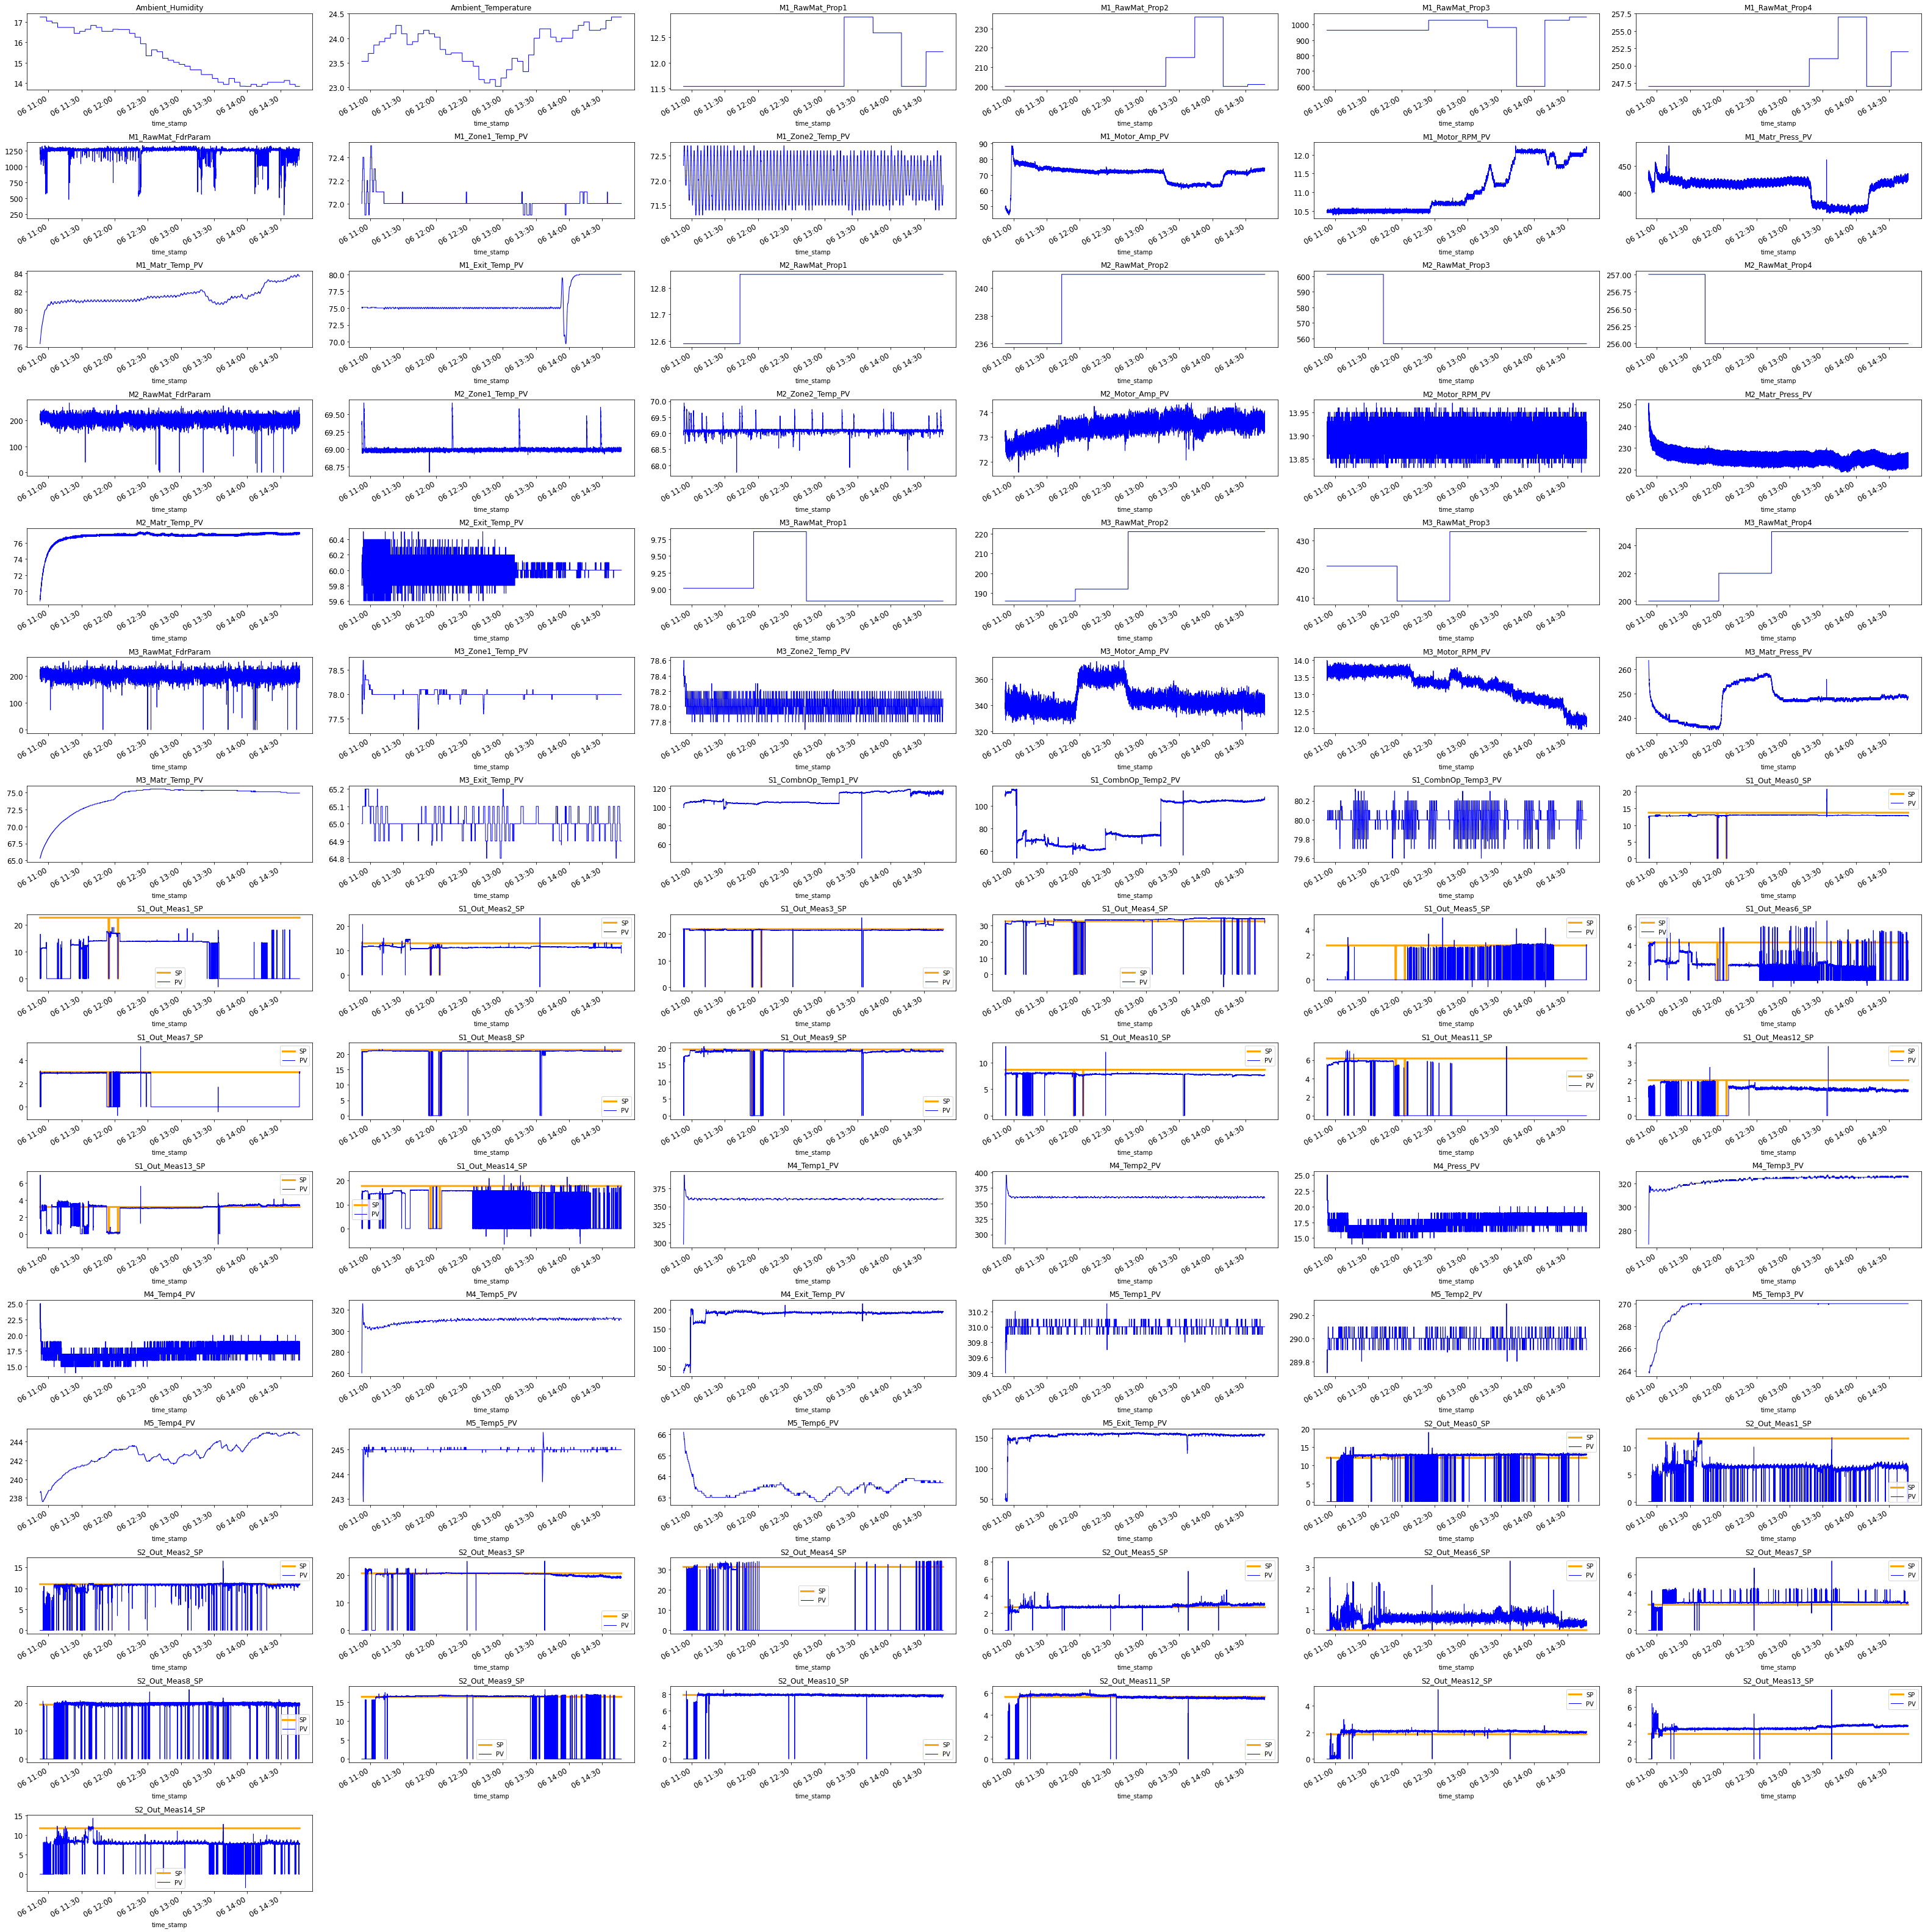

In [8]:
# Generate Plots for all columns, with PV and SP columns on the same subplots 
plotcol_list=df.columns.drop(PV_col_list)
gspec=gridspec.GridSpec(15,6)
fig=plt.figure()
fig.set_size_inches([44,44])
count=0
for i in range(0,15):
    for j in range(0,6):
        count+=1
        if count>85:
            break
        thisplot=plt.subplot(gspec[i,j])
        this_col=plotcol_list[count-1]
        if 'SP' in this_col:
          PV_col = this_col[:len(this_col)-2] + 'PV'
          df[this_col].plot(c='orange',linewidth=3,label='SP',legend=True)
          ax=thisplot.figure.gca()
          df[PV_col].plot(c='b',linewidth=1,ax=ax,label='PV',legend=True)
        else:  
          df[this_col].plot(linewidth=1,c='b')
        thisplot.figure.set_size_inches([44,44])
        thisplot.figure.tight_layout(h_pad=1.0)
        thisplot.set_title(f"{this_col}",fontsize=12)
        thisplot.tick_params(axis='y', labelsize=12)
        thisplot.tick_params(axis='x', labelsize=12)     

PDF version of plots has been been saved to Github.

Some observations:
*   SP trends for all 15 S1 measurements show transient dips to 0.0 between 11:54:27 and 11:55:01 (approx 35 secs) and between 12:02:50 and 12:03:10 (approx 20 secs). Multiples dips observed in the S2 measurement sensors (not just during the 2 instances observed for the S1 sensors. 
SPECULATION: the 0.0-dips refer to instances of power supply loss to the sensors, interference from a common external source, or potential sensor reliability issues.
PROPOSAL: to obtain some useful information about the S1 and S2 trends, might consider missing value imputations for the instances of the 0.0-dips
*   Data spikes/dips in multiple measurements, e.g.: M4_Press_PV, M5_Temp2_PV, M2_Motor_RPM_PV, M2_Exit_Temp_PV. These spikes/dips could be due to signal noise. Ranges for these distortions appear to be small compared to the range of the signals themselves.
*   Some S2 meas. trends showing controller saturation, as the PV's are not able to consistently track their SP's, e.g.: S2_Out_Meas0, S2_Out_Meas1, S2_Out_Meas6, S2_Out_Meas13, S2_Out_Meas14
*   List item





Next step is to take a closer look at individual plots, and attempt do some clean-up of those with heavy spikes/dips. Need to clean-up these variables before further analyses can be performed on them.

Will first define a function for enlarged plot of any chosen df column. From the enlarged plots, will determine the individual clip limits for the plots with spikes/dips.

Next, will  define a function for removing these spikes/dips and interpolating. Will implement the idea presented in stackoverflow post: https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python

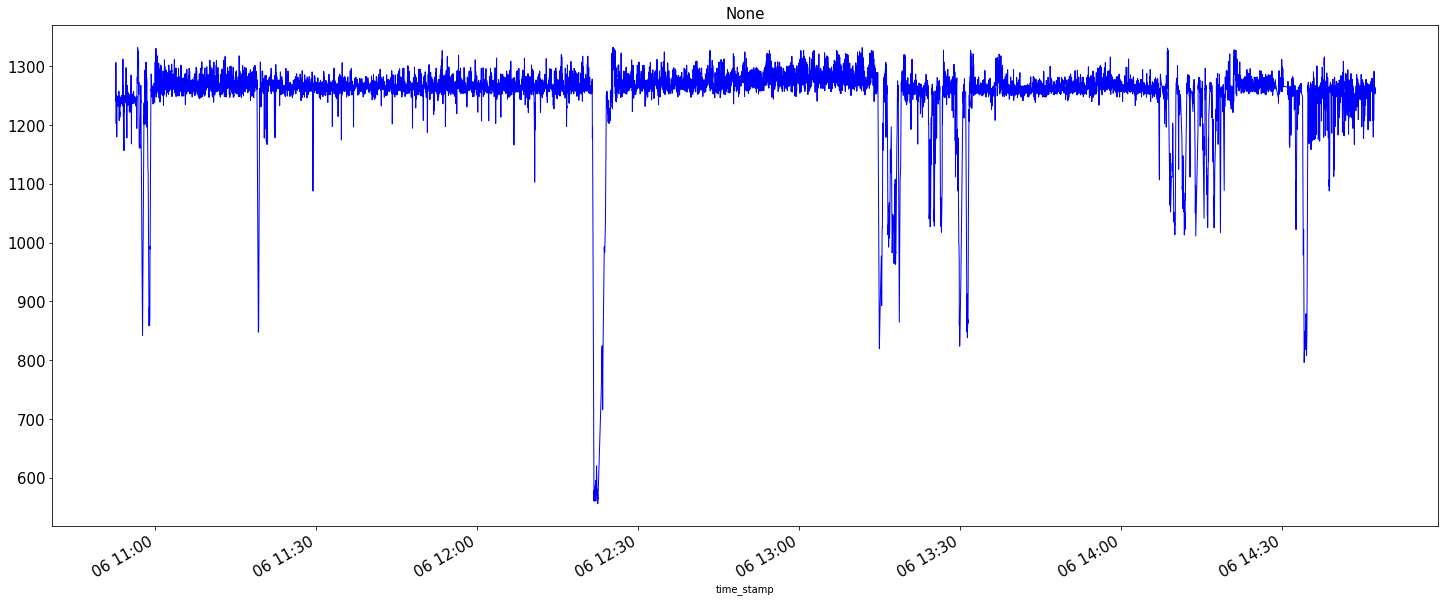

In [33]:
# Define function for individual plots
def plot_big(df_in):
  global fig
  fig=plt.figure()
  fig.set_size_inches([20,8])
  df_in.plot(linewidth=1,c='b')
  fig.tight_layout(h_pad=1.0)
  col_name=df_in.name
  fig.gca().set_title(f"{col_name}",fontsize=15)
  fig.gca().tick_params(axis='y', labelsize=15)
  fig.gca().tick_params(axis='x', labelsize=15)
  
# Define function for clipping/interpolation
# DELTA - Distance away from the FBEWMA that data should be removed. 
# HIGH_CLIP - clip data above this value:
# LOW_CLIP - clip data below this value:
# SPAN - How many samples to run the FBEWMA over.
def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > high_clip) | (np_unclipped < low_clip)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return pd.Series(np_clipped)
    
def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma

def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return pd.Series(np_remove_outliers,index=df.index)
        
def de_spike(df_in,HIGH_CLIP,LOW_CLIP,SPAN,DELTA):
    df=df_in.copy(deep=True)
    df['y_clipped'] = clip_data(df.tolist(), HIGH_CLIP, LOW_CLIP)
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()
    return df['y_interpolated']
    
plot_big(de_spike(df['M1_RawMat_FdrParam'],1350,500,5,50))
#ax=fig.gca()
#pd.Series(df['M1_RawMat_FdrParam'].values).plot(ax=ax,c='orange',linewidth=0.5)

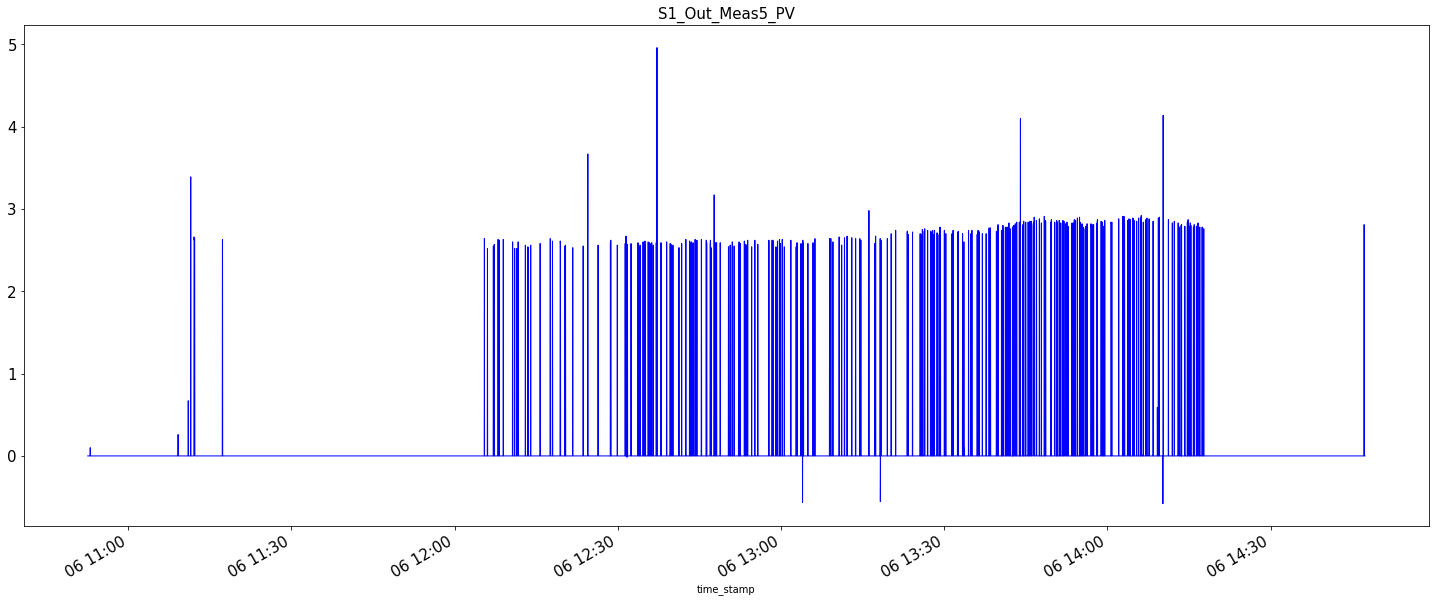

In [14]:
plot_big(df['S1_Out_Meas5_PV'])
#fig.gca().set_xlim(['2019-03-06 12:20:00','2019-03-06 12:25:00']);
#fig.gca().set_ylim([1100,1300]);

**------------------Work Cells below here----------------------**

<Figure size 432x288 with 0 Axes>

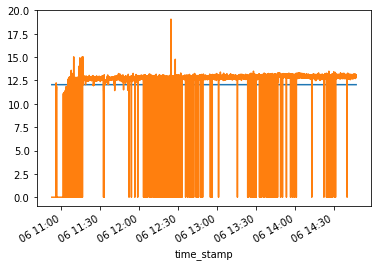

In [11]:
plt.figure()
ax=plt.figure().gca()
df['S2_Out_Meas0_SP'].plot(ax=ax)
df['S2_Out_Meas0_PV'].plot(ax=ax)

In [12]:
#df[['S1_Out_Meas0_SP','M3_Motor_Amp_PV']].loc['2019-03-06 11:53:33':'2019-03-06 12:00:33']
df.eq(0.0).sum(axis=0).sort_values(ascending=False)[:20]

S1_Out_Meas5_PV     13400
S2_Out_Meas4_PV     12754
S1_Out_Meas11_PV    10462
S1_Out_Meas7_PV      8761
S1_Out_Meas1_PV      5900
S1_Out_Meas14_PV     5005
S1_Out_Meas6_PV      4703
S2_Out_Meas9_PV      4198
S1_Out_Meas12_PV     3188
S2_Out_Meas0_PV      1224
S2_Out_Meas8_PV       973
S2_Out_Meas14_PV      912
S1_Out_Meas8_PV       777
S2_Out_Meas3_PV       772
S1_Out_Meas9_PV       722
S2_Out_Meas1_PV       676
S2_Out_Meas10_PV      635
S2_Out_Meas11_PV      628
S2_Out_Meas2_PV       604
S2_Out_Meas7_PV       346
dtype: int64

In [13]:



#plt.figure()
#test=list(df[df['S1_Out_Meas5_PV'].le(1.5)|df['S1_Out_Meas5_PV'].ge(2.9)].loc[:,'S1_Out_Meas5_PV'].values)
#df['S1_Out_Meas5_PV']=df['S1_Out_Meas5_PV'].replace(to_replace=test,value=np.nan)
#df['S1_Out_Meas5_PV'].interpolate('pad').plot()

**-- Code below is based on a response to a question on stackoverflow - https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python --**

# Source: https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python

# import logging
import numpy as np
import pandas as pd

#logging.basicConfig(datefmt='%H:%M:%S',
#                    stream=sys.stdout, level=logging.DEBUG,
#                    format='%(asctime)s %(message)s')

# Distance away from the FBEWMA that data should be removed.
DELTA = 0.1

# clip data above this value:
HIGH_CLIP = 2.1

# clip data below this value:
LOW_CLIP = -2.1

# random values above this trigger a spike:
RAND_HIGH = 0.98

# random values below this trigger a negative spike:
RAND_LOW = 0.02

# How many samples to run the FBEWMA over.
SPAN = 10

# spike amplitude
SPIKE = 2


def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > HIGH_CLIP) | (np_unclipped < LOW_CLIP)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return np_clipped.tolist()


def create_sample_data():
    ''' Create sine wave, amplitude +/-2 with random spikes. '''
    x = np.linspace(0, 2*np.pi, 1000)
    y = 2 * np.sin(x)
    df = pd.DataFrame(list(zip(x,y)), columns=['x', 'y'])
    df['rand'] = np.random.random_sample(len(x),)
    # create random positive and negative spikes
    cond_spike_high = (df['rand'] > RAND_HIGH)
    df['spike_high'] = np.where(cond_spike_high, SPIKE, 0)
    cond_spike_low = (df['rand'] < RAND_LOW)
    df['spike_low'] = np.where(cond_spike_low, -SPIKE, 0)
    df['y_spikey'] = df['y'] + df['spike_high'] + df['spike_low']
    return df


def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma
    
    
def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return np_remove_outliers

    
def main():
    df = create_sample_data()
    df['y_clipped'] = clip_data(df['y_spikey'].tolist(), HIGH_CLIP, LOW_CLIP)
    print(f"Data type is {type(df['y_clipped'])}")  # Added this line for troubleshooting
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()
    
    ax = df.plot(x='x', y='y_spikey', color='blue', alpha=0.5)
    ax2 = df.plot(x='x', y='y_interpolated', color='black', ax=ax)
    
main()